# Introduction

Synth (Subnet 50) redefines how synthetic financial data is modelled and utilized for predictive intelligence.

Powered by Bittensor’s decentralized intelligence network, Synth replaces the traditional, opaque data models with an open, verifiable, and continuously evolving synthetic data layer where the models compete, refine, and enhance monte-carlo simulations of price forecasts to unprecedented levels.

- [Visit their website](https://www.synthdata.co/)
- [Read more in the whitepaper](https://mode-network.github.io/synth-subnet/Synth%20Whitepaper%20v1.pdf)

# Setup

The first steps to get started are:
1. Install the [package dedicated to this competition](https://github.com/crunchdao/synth-crunch)

In [4]:
%pip install synth-crunch

# Your model

## Setup

In [11]:
from synth_crunch.baseline import convert_prices_to_time_format
from synth_crunch import pyth
import numpy as np
from datetime import datetime, timedelta
from typing import Any
from scipy.stats import t

# Import the synth classes
from synth_crunch import Asset, SynthMiner

## Implementation

### `SynthMiner.generate_simulations()`

You must implement a class with the mandatory function, generate_simulations().

This function will be called each time the protocol asks your model to make predictions.

You must predict the possible paths (called simulations), of an `asset` at regular intervals (`time_increment`), for a determined amount of time (`time_length`).

In [14]:
class MyMiner(SynthMiner):

    def __init__(self):
        # Initialize your state in the constructor:
        # - load your model
        # - warmup your code
        pass

    def generate_simulations(
        self,
        asset: Asset,  # can only be "BTC", "ETH", "XAU" or "SOL"
        current_price: float,
        start_time: str,
        time_increment: int,
        time_length: int,
        num_simulations: int,
    ) -> list[list[dict[str, Any]]]:
        """
        Generate simulated price paths.

        Parameters:
            asset (str): The asset to simulate.
            current_price (float): The current price of the asset to simulate.
            start_time (str): The start time of the simulation.
            time_increment (int): Time increment in seconds (typically 300 for 5min).
            time_length (int): Total time length in seconds (typically 86400 for 24h).
            num_simulations (int): Number of simulation runs (typically 100).

        Returns:
            list[list[dict[str, Any]]]: Simulated price paths in time format.
        """
        if not start_time:
            start_time = datetime.now().isoformat()  # Fallback if empty

        past_prices = pyth.get_price_history(
            asset=asset,
            from_=datetime.fromisoformat(start_time) - timedelta(days=30),  # Longer history for robustness
            to=datetime.fromisoformat(start_time),
            resolution="5minute",
        ).tolist()

        # Parameter estimation
        if len(past_prices) < 2:
            mu = 0.0
            sigma = 0.01  # Fallback low volatility
        else:
            log_prices = np.log(past_prices)
            returns = np.diff(log_prices)
            mu = 0.0  # No historical drift for short-term forecasts

            # EWMA volatility (alpha=0.94 standard for finance)
            def get_ewma_vol(rets, alpha=0.94):
                if len(rets) == 0:
                    return 0.01
                sq_rets = rets ** 2
                var_ew = np.zeros_like(sq_rets)
                var_ew[0] = sq_rets[0]
                for i in range(1, len(sq_rets)):
                    var_ew[i] = alpha * var_ew[i - 1] + (1 - alpha) * sq_rets[i]
                return np.sqrt(var_ew[-1])

            sigma = get_ewma_vol(returns)

            # Asset-specific scaling (from baseline notebook)
            multipliers = {"BTC": 3.0, "ETH": 1.25, "XAU": 0.5, "SOL": 0.75}
            sigma *= multipliers.get(asset, 1.0)

        num_steps = time_length // time_increment
        simulations = self.simulate_crypto_price_paths(
            current_price=current_price,
            mu=mu,
            sigma=sigma,
            num_steps=num_steps,
            num_simulations=num_simulations,
        )

        predictions = convert_prices_to_time_format(
            prices=simulations.tolist(),
            start_time=start_time,
            time_increment=time_increment,
        )

        return predictions

    def simulate_single_price_path(
        self,
        current_price: float,
        mu: float,
        sigma: float,
        num_steps: int,
    ):
        """
        Simulate a single crypto asset price path using improved GBM (EWMA vol, t-shocks).
        """
        # GBM per-step (treat 5min as unit; no dt scaling)
        loc = mu - 0.5 * sigma ** 2
        scale = sigma
        df = 5  # Degrees of freedom for fat tails
        scale_t = scale * np.sqrt((df - 2) / df)  # Normalize t variance to match normal

        shocks = t.rvs(df=df, loc=loc, scale=scale_t, size=num_steps)

        price_path = np.zeros(num_steps + 1)
        price_path[0] = current_price
        for i in range(1, num_steps + 1):  # Renamed to 'i' to avoid shadowing 't'
            price_path[i] = price_path[i - 1] * np.exp(shocks[i - 1])

        return price_path

    def simulate_crypto_price_paths(
        self,
        current_price: float,
        mu: float,
        sigma: float,
        num_steps: int,
        num_simulations: int,
    ):
        """
        Simulate multiple crypto asset price paths.
        """
        price_paths = []
        for _ in range(num_simulations):
            price_path = self.simulate_single_price_path(
                current_price,
                mu,
                sigma,
                num_steps,
            )
            price_paths.append(price_path)

        return np.array(price_paths)

## Local testing

### Using historical data

We recommend using historical data for quick iterations because you can be scored immediately.

Once you have generated your simulations, they are validated to ensure that you are ready for the network.

In [15]:
# Import the function
from synth_crunch import test_historical

# Run the tester
result = test_historical(
    # You must instantiate your miner.
    MyMiner(),

    # Specify which asset you want to run with: "BTC," "ETH," "XAU," or "SOL".
    "BTC",

    # Customize the start date (default to 1st of February 2024 at 02:00 PM).
    start=datetime(2024, 2, 1, 14),

    # Customize the time increment between two predictions (default to 5min).
    time_increment=300,

    # Customize the duration of a simulation; it must be a divisor of the time increment (default to 24h).
    time_length=86400,

    # Customize the number of simulations to run (default to 300).
    num_simulations=10,
)

#### Visualize your simulations

The utility provides a quick way to visualize your simulations.

To clearly see the different paths, we suggest keeping the number of simulations low.

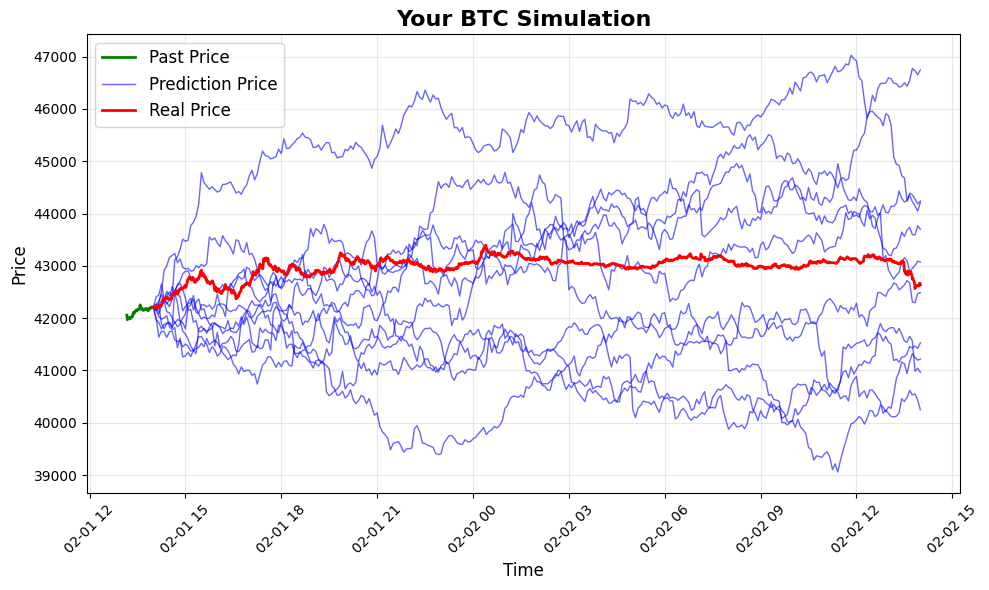

In [16]:
# Import the function
from synth_crunch import visualize_simulations

visualize_simulations(
    result,
)

#### Score your simulations

Your simulations will be scored using [Synth Subnet's scoring function](https://github.com/mode-network/synth-subnet/blob/d076dc3bcdf93256a278dfec1cbe72b0c47612f6/synth/validator/crps_calculation.py#L5).

In [17]:
# Import the function
from synth_crunch import score_simulations

# Score your results
scored_result = score_simulations(
    result,
)

print("My miner score is:", scored_result.score)
print()

print("More details:")
print(scored_result.score_summary)

My miner score is: 4700.504507618703

More details:
  Interval        CRPS
      5min 2825.382409
     30min 1299.959636
     3hour  453.801574
24hour_abs  121.360889
   Overall 4700.504508


### Using live data

Once you're ready, you can run your miner against live data.

However, the longer your `time_length` is, the longer you will have to wait to score your simulations.

In [18]:
# Import the function
from synth_crunch import test_live

# Run the tester
result = test_live(
    # You must instantiate your miner.
    MyMiner(),

    # Specify which asset you want to run with: "BTC," "ETH," "XAU," or "SOL".
    "BTC",

    # Customize the time increment between two predictions (default to 1min).
    time_increment=60,

    # Customize the duration of a simulation; it must be a divisor of the time increment (default to 5min).
    time_length=300,

    # Customize the number of simulations to run (default to 100).
    num_simulations=100,
)

#### Visualize your simulations

You can also visualize the different paths generated by your miner. The only difference is that there are no lines for the actual price.

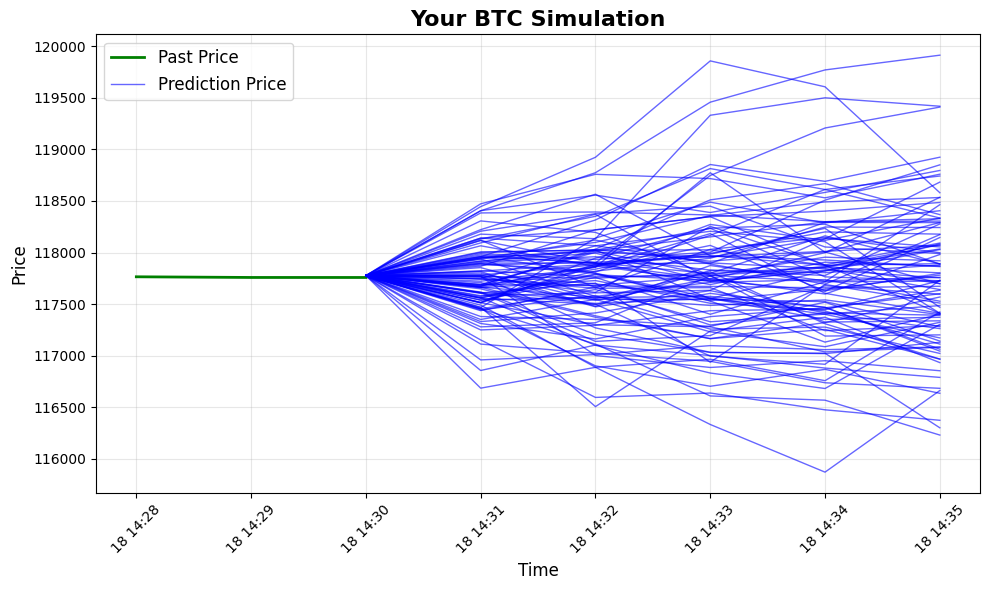

In [19]:
# Import the function
from synth_crunch import visualize_simulations

visualize_simulations(
    result,
    show_past=2,
)

In [20]:
# Import the function
from synth_crunch import score_simulations

# Score your results
scored_result = score_simulations(
    result,
)

print("My miner score is:", scored_result.score)
print()

print("More details:")
print(scored_result.score_summary)

Waiting 308 seconds (include extras to be safe) until the simulations target are resolved. Do an interrupt (Ctrl+C) if you want to stop early.


Waiting for targets to resolve:   0%|          | 0/308 [00:00<?, ?s/s]

My miner score is: 25.49501197330226

More details:
  Interval      CRPS
      5min 12.757984
24hour_abs 12.737028
   Overall 25.495012


### Querying more historical data

To meet your training needs, you can query the historical data provided by [Pyth](https://www.pyth.network/).

In [21]:
# Import the function
from synth_crunch import pyth

prices = pyth.get_price_history(
    # Specify which asset you want to get data of: "BTC," "ETH," "XAU," or "SOL".
    asset="BTC",

    # Start time of the data
    from_=datetime(2024, 1, 1),

    # End time of the data
    to=datetime(2024, 6, 1),

    # Resolution of the data, can be "minute", "2minute", "5minute", "15minute", "30minute", "hour", "2hour", "4hour", "6hour", "12hour", "day", "week" or "month".
    resolution="30minute",
)

prices

,price
timestamp,
2024-01-01 00:00:00+00:00,42416.672160
2024-01-01 00:30:00+00:00,42465.130000
2024-01-01 01:00:00+00:00,42485.409351
2024-01-01 01:30:00+00:00,42598.655471
2024-01-01 02:00:00+00:00,42537.854208
...,...
2024-05-31 22:00:00+00:00,67596.061121
2024-05-31 22:30:00+00:00,67479.705000
2024-05-31 23:00:00+00:00,67197.459620


# Submit your Notebook

To submit your work, you must:
1. Download your Notebook from Colab
2. Upload it to the platform
3. Create a run to validate it

### >> https://hub.crunchdao.io/competitions/synth/submit/notebook